# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 1        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 4        # no. CPU cores (data loading)

    # general
    version  = 9      # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 13353  # random state

    # data
    num_folds = 5      # number of CV folds
    data_pl   = False  # False or percentage of appended pseudo-labeled data 
    data_old  = True   # whether to append nromalized old data to train
    data_off   = False  # whether to include off channels as negative targets
    
    # wave transformation
    transform = 'q'
    q_sr      = 2048
    q_fmin    = 20
    q_fmax    = 1024
    q_hop     = 32
    q_bins    = 8
    
    # image processing
    p_transpose = 0                 # prob. of transpose
    p_flip       = 0                 # prob. of  vertical and horizontal flips 
    p_aug       = 0                 # prob. of augmentations except for flips
    ssr         = [0.10, 0.10, 360] # shift, scale, rotation limits
    huesat      = [0, 0, 0]         # hue, saturation, value limits
    bricon      = [0, 0]            # brightness, contrast limits
    blur_limit  = 0                 # blur limit
    cutmix      = [0, 1]            # cutmix batch-level probability, alpha
    normalize   = False             # pixel normalization after augmentation
        
    # architecture
    backbone   = 'tf_efficientnet_b0_ns'  # CNN backbone   
    pretrained = 'imagenet'             # pretrained weights [False, 'imagenet', path]
    
    # training
    num_epochs    = 8      # no. epochs per fold
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_size    = 64     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumalation
    use_fp16      = True   # mixed precision mode 
    grad_clip     = False  # max gradient norm (False or float)
    batch_verbose = False  # print loss every n batches
    
    # loss function
    loss_fn = 'BCE'  # loss ['BCE', 'FC']
    smooth  = False  # label smoothing (False or float)
    
    # LR and optimizer
    lr    = 3e-4       # starting learning rate
    optim = 'madgrad'  # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    decay = 0          # weight decay of optimizer (L2 regularization)

    # scheduler
    warmup       = 1         # no. epochs for warmup
    scheduler    = 'cosine'  # LR scheduler after warmup
    upd_on_batch = True      # update LR after every batch (or epoch)
    
    # inference
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 256   # no. images per batch 
    num_tta          = 1     # no. TTA flips (between 1 and 8)

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['save_all']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2

# 2. PREPARATIONS

In [4]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade -U albumentations
    !pip install git+'https://github.com/ildoonet/pytorch-gradual-warmup-lr.git'
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd
import torch

import os
import sys
import time
import pickle

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

In [5]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/seti-code')  

# utilities
from utilities import *

# visualization
from sample_batch import sample_batch

# training and inference
from run_training import run_training
from run_inference import run_inference

In [6]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/seti-breakthrough-listen/'
    CFG['out_path']   = ''

In [7]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune 
    neptune.init(api_token             = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZjVlMTZiZS1kYjcyLTRmZmQtYjJhYS0xMmIyYzdiNzFkMzcifQ==',
                 project_qualified_name = 'ml_comps/g2net')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

https://app.neptune.ai/ml_comps/g2net/e/GNET-26


In [8]:
####### SETTINGS

warnings.filterwarnings('ignore')        # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 13353...


# 3. DATA PREP

In [9]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'training_labels.csv')
df['file_path'] = df['id'].apply(lambda x: get_train_file_path(x, CFG))

# update info
CFG['num_classes'] = df['target'].nunique()
print('no. classes: {}'.format(CFG['num_classes']))

# partitioning
folds = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'])
for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(df, df['target'])):
    df.loc[val_idx, 'fold'] = int(fold_idx)
df['fold'] = df['fold'].astype(int)

# display
print(f'train shape: {df.shape}')
pd.crosstab(df['fold'], df['target'])

no. classes: 2
train shape: (560000, 4)


target,0,1
fold,,
0,56014,55986
1,56014,55986
2,56014,55986
3,56014,55986
4,56014,55986


In [10]:
###### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'sample_submission.csv')
sub['file_path'] = sub['id'].apply(lambda x: get_test_file_path(x, CFG))

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print(f'test shape: {sub.shape}')
display(sub.head())

test shape: (226000, 3)


,id,target,file_path
0,00005bced6,0.5,../input/test/0/0/0/00005bced6.npy
1,0000806717,0.5,../input/test/0/0/0/0000806717.npy
2,0000ef4fe1,0.5,../input/test/0/0/0/0000ef4fe1.npy
3,00020de251,0.5,../input/test/0/0/0/00020de251.npy
4,00024887b5,0.5,../input/test/0/0/0/00024887b5.npy


- setting random seed to 13353...
- loading time: 0.1518 vs 0.1010 seconds
- inputs shape: torch.Size([3, 1, 46, 385]) vs torch.Size([3, 1, 46, 385])
- pixel values: 0.00 | 0.02 | 0.78 vs 0.00 | 0.02 | 0.78


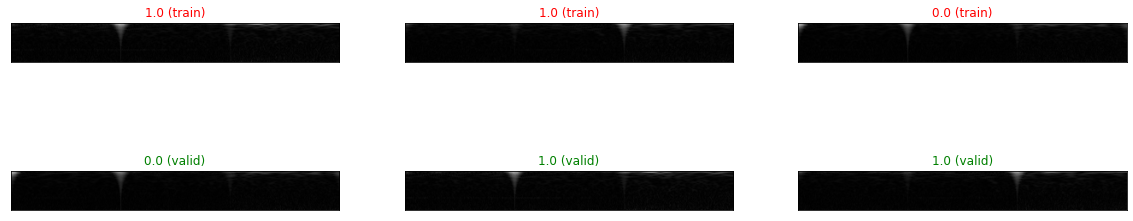

In [11]:
###### SHOW SAMPLE BATCH

_ = sample_batch(CFG, df, sample_size = 3, batch_idx = 1)

# 4. CROSS-VALIDATION

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
FOLD 1/5
-------------------------------------------------------
- no. images: train - 448000, valid - 112000
- setting random seed to 13353...
-  p(augment): 0
-------------------------------------------------------


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

-- epoch 1/8 | lr = 0.000300 | trn_loss = 0.4747 | val_loss = 0.4695 | val_auc = 0.8529 | 15.78 min


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

-- epoch 2/8 | lr = 0.000285 | trn_loss = 0.4381 | val_loss = 0.4382 | val_auc = 0.8563 | 15.73 min


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

-- epoch 3/8 | lr = 0.000244 | trn_loss = 0.4304 | val_loss = 0.4377 | val_auc = 0.8571 | 16.02 min


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

-- epoch 4/8 | lr = 0.000183 | trn_loss = 0.4249 | val_loss = 0.4333 | val_auc = 0.8589 | 15.81 min


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

-- epoch 5/8 | lr = 0.000117 | trn_loss = 0.4188 | val_loss = 0.4358 | val_auc = 0.8599 | 15.92 min


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

-- epoch 6/8 | lr = 0.000056 | trn_loss = 0.4108 | val_loss = 0.4320 | val_auc = 0.8584 | 15.69 min


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

-- epoch 7/8 | lr = 0.000015 | trn_loss = 0.3982 | val_loss = 0.4403 | val_auc = 0.8550 | 15.64 min


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

-- epoch 8/8 | lr = 0.000000 | trn_loss = 0.3779 | val_loss = 0.4578 | val_auc = 0.8501 | 16.17 min
-------------------------------------------------------
Best: score = 0.8599 (epoch 5)
-------------------------------------------------------


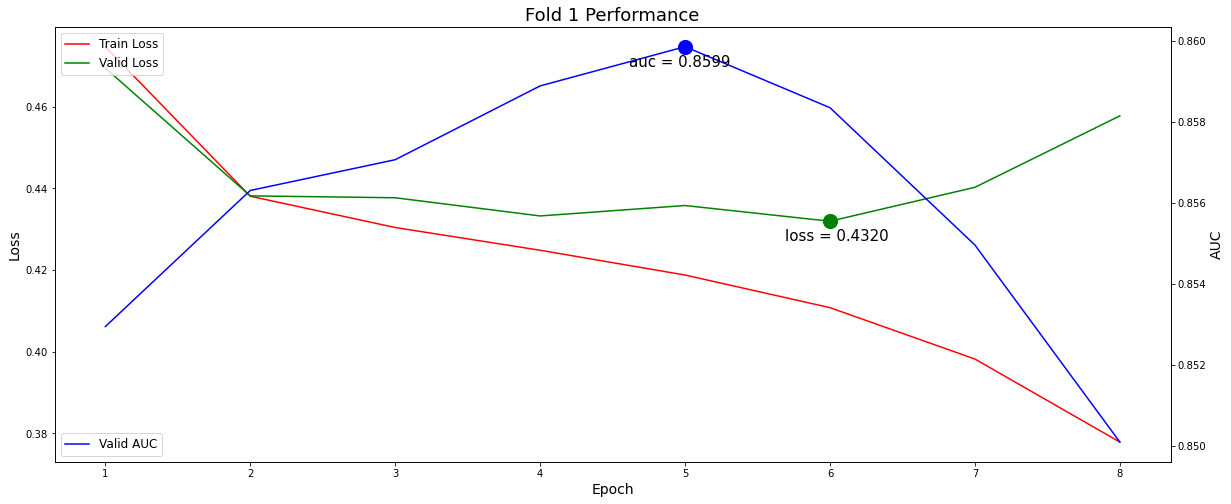

-------------------------------------------------------
FOLD 2/5
-------------------------------------------------------
- no. images: train - 448000, valid - 112000
- setting random seed to 13354...
-  p(augment): 0
-------------------------------------------------------


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

-- epoch 1/8 | lr = 0.000300 | trn_loss = 0.4742 | val_loss = 0.4494 | val_auc = 0.8520 | 15.70 min


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

In [ ]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (CFG, df),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# 5. INFERENCE

In [ ]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

In [ ]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
oof_score = []
for fold in range(CFG['num_folds']):
    oof_score.append(get_score(oof.loc[oof['fold'] == fold, 'target'],
                               oof.loc[oof['fold'] == fold, 'pred']))
CFG['oof_score_tta'] = np.mean(oof_score)

# print performance
print('-' * 30)
print('OOF with TTA = {:.4f}'.format(CFG['oof_score_tta']))
print('-' * 30)

In [ ]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score_tta', CFG['oof_score_tta'])
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')
    neptune.stop()

# 7. ERROR ANALYSIS

In [ ]:
###### SHOW SAMPLE PREDICTIONS

from plot_predictions import plot_predictions
plot_predictions(CFG, fold = 0, sample_size = 5)